# XLM-RoBERTa -> Longformer

This notebook replicates the procedures descriped in the [Longformer paper](https://arxiv.org/abs/2004.05150) to build a "long" version of [XLM-RoBERTa](https://huggingface.co/xlm-roberta-base) without further pretraining. The result model is intended to be fine-tuned on a downstream task.

In [1]:
src_model_name = 'xlm-roberta-base'
new_model_name = 'hyperonym/xlm-roberta-longformer-base-16384'

In [2]:
src_model_weight_prefix = '.*/roberta/'
new_model_weight_prefix = '.*/longformer/'

In [3]:
attention_window_size = 256
max_sequence_length = 16384 # 512 * 32

## Install dependencies

Install TensorFlow:

In [ ]:
!pip install tensorflow==2.11.0

Install Hugging Face libraries:

In [ ]:
!pip install transformers huggingface_hub

Check if GPU is available:

In [6]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [7]:
!nvidia-smi

Sun Jan 29 12:48:21 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    27W /  70W |    326MiB / 15360MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Build model

In [8]:
from transformers import AutoConfig, LongformerConfig, TFAutoModel

### Load source model

In [ ]:
src_config = AutoConfig.from_pretrained(src_model_name)

In [ ]:
src_model = TFAutoModel.from_pretrained(src_model_name)

### Prepare dummy inputs

In [11]:
def dummy_inputs():
  input_ids = tf.convert_to_tensor([
    [7, 6, 0, 0, 1],
    [1, 2, 3, 0, 0],
    [0, 0, 0, 4, 5]
  ], dtype=tf.int32)
  attention_mask = tf.convert_to_tensor([
    [1, 1, 0, 0, 1],
    [1, 1, 1, 0, 0],
    [1, 0, 0, 1, 1]
  ], dtype=tf.int32)
  global_attention_mask = tf.convert_to_tensor([
    [0, 0, 0, 0, 1],
    [0, 0, 1, 0, 0],
    [0, 0, 0, 0, 1]
  ], dtype=tf.int32)
  return {
    'input_ids': input_ids,
    'attention_mask': attention_mask,
    'global_attention_mask': global_attention_mask,
  }

### Create model from config

In [12]:
config = LongformerConfig()

Set Longformer-specific hyperparameters:

In [13]:
config.attention_window = attention_window_size
config.max_position_embeddings = max_sequence_length + 2
config.sep_token_id = src_config.eos_token_id

Copy other hyperparameters from the source config:

In [14]:
config.attention_probs_dropout_prob = src_config.attention_probs_dropout_prob
config.bos_token_id = src_config.bos_token_id
config.classifier_dropout = src_config.classifier_dropout
config.eos_token_id = src_config.eos_token_id
config.hidden_act = src_config.hidden_act
config.hidden_dropout_prob = src_config.hidden_dropout_prob
config.hidden_size = src_config.hidden_size
config.initializer_range = src_config.initializer_range
config.intermediate_size = src_config.intermediate_size
config.layer_norm_eps = src_config.layer_norm_eps
config.num_attention_heads = src_config.num_attention_heads
config.num_hidden_layers = src_config.num_hidden_layers
config.pad_token_id = src_config.pad_token_id
config.position_embedding_type = src_config.position_embedding_type
config.type_vocab_size = src_config.type_vocab_size
config.vocab_size = src_config.vocab_size

Build new model from config:

In [15]:
model = TFAutoModel.from_config(config)

In [16]:
_ = model(dummy_inputs())

### Collect weights and names

In [17]:
import re

Collect weights in the source model:

In [18]:
src_weight_arrays = src_model.get_weights()

In [19]:
src_weight_indices = dict()
for i, weight in enumerate(src_model.roberta.weights):
  name = re.sub(src_model_weight_prefix, '',  weight.name)
  src_weight_indices[name] = i

Collect weights in the new model:

In [20]:
weight_arrays = model.get_weights()

In [21]:
weight_indices = dict()
for i, weight in enumerate(model.longformer.weights):
  name = re.sub(new_model_weight_prefix, '',  weight.name)
  weight_indices[name] = i

### Copy pretrained weights

“Since MLM pretraining is expensive, we continue pretraining from the RoBERTa (Liu et al., 2019) released checkpoint, while only making the minimal changes necessary to support Longformer’s attention mechanism.” (Beltagy et al., 2020, p. 6)

In [22]:
for name in src_weight_indices:
  src_weight = src_weight_arrays[src_weight_indices[name]]
  weight = weight_arrays[weight_indices[name]]
  if src_weight.shape == weight.shape:
    weight_arrays[weight_indices[name]] = src_weight.copy()
  elif name != 'embeddings/position_embeddings/embeddings:0':
    raise ValueError(f'shape of {name} does not match')

### Copy position embeddings

“To leverage RoBERTa’s pretrained weights, instead of randomly initializing the new position embeddings, we initialize them by copying the 512 position embeddings from RoBERTa multiple times as analysis of BERT’s attention heads shows a strong learned bias to attending to local context, including the previous or next token (Clark et al., 2019). Using the copy initialization preserves this local structure everywhere except at the partition boundaries.” (Beltagy et al., 2020, p. 6)

“The following two rows show the performance of Longformer before pretraining with randomly initialized position embeddings and with copied position embeddings. The significant difference indicates the importance of the copy initialization, and the relative small difference between the RoBERTa BPC and the initialized BPC indicates that our sliding window attention is working well with the RoBERTa weights.” (Beltagy et al., 2020, p. 7)

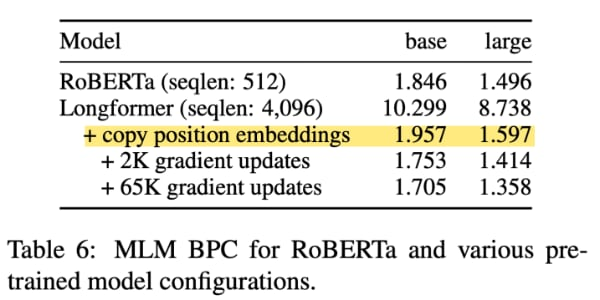

In [23]:
import numpy as np

In [24]:
src_position_index = src_weight_indices['embeddings/position_embeddings/embeddings:0']
src_position_embeddings = src_weight_arrays[src_position_index]
src_position_embeddings.shape

(514, 768)

In [25]:
position_embeddings = src_position_embeddings[2:]
position_copies = max_sequence_length // (src_config.max_position_embeddings - 2)
position_embeddings = np.tile(position_embeddings, (position_copies, 1))
position_embeddings = np.concatenate((src_position_embeddings[:2], position_embeddings))
position_embeddings.shape

(16386, 768)

In [26]:
position_index = weight_indices['embeddings/position_embeddings/embeddings:0']
weight_arrays[position_index] = position_embeddings

### Copy linear projections

“We use two sets of projections, Qs, Ks, Vs to compute attention scores of sliding window attention, and Qg, Kg, Vg to compute attention scores for the global attention.” (Beltagy et al., 2020, p. 4)

“Qg, Kg, Vg are all initialized with values that match Qs, Ks, Vs.” (Beltagy et al., 2020, p. 4)

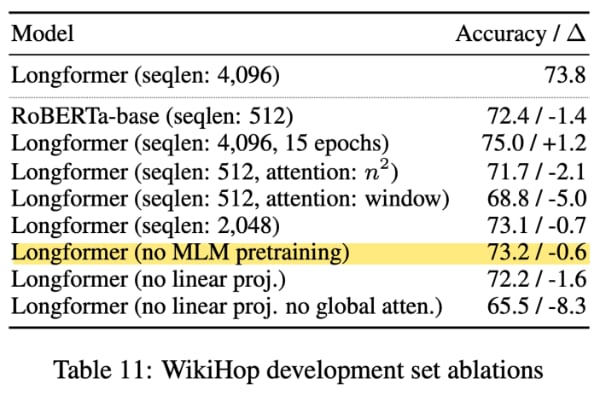

In [27]:
for i in range(config.num_hidden_layers):
  prefix = f'encoder/layer_._{i}/attention/self'

  key_global_bias = weight_indices[f'{prefix}/key_global/bias:0']
  key_global_kernel = weight_indices[f'{prefix}/key_global/kernel:0']
  query_global_bias = weight_indices[f'{prefix}/query_global/bias:0']
  query_global_kernel = weight_indices[f'{prefix}/query_global/kernel:0']
  value_global_bias = weight_indices[f'{prefix}/value_global/bias:0']
  value_global_kernel = weight_indices[f'{prefix}/value_global/kernel:0']

  key_bias = src_weight_indices[f'{prefix}/key/bias:0']
  key_kernel = src_weight_indices[f'{prefix}/key/kernel:0']
  query_bias = src_weight_indices[f'{prefix}/query/bias:0']
  query_kernel = src_weight_indices[f'{prefix}/query/kernel:0']
  value_bias = src_weight_indices[f'{prefix}/value/bias:0']
  value_kernel = src_weight_indices[f'{prefix}/value/kernel:0']

  weight_arrays[key_global_bias] = src_weight_arrays[key_bias].copy()
  weight_arrays[key_global_kernel] = src_weight_arrays[key_kernel].copy()
  weight_arrays[query_global_bias] = src_weight_arrays[query_bias].copy()
  weight_arrays[query_global_kernel] = src_weight_arrays[query_kernel].copy()
  weight_arrays[value_global_bias] = src_weight_arrays[value_bias].copy()
  weight_arrays[value_global_kernel] = src_weight_arrays[value_kernel].copy()

### Apply weights and biases 

In [28]:
model.longformer.set_weights(weight_arrays)

### Compare model outputs

In [29]:
ids = dummy_inputs()['input_ids']

Get output of the source model:

In [30]:
src_output = src_model(ids).last_hidden_state.numpy()

Get output of the "long" version:

In [31]:
output = model(ids).last_hidden_state.numpy()

The outputs should be identical for short input sequences:

In [37]:
assert np.allclose(src_output, output, atol=1e-3)

## Build tokenizer

In [38]:
from transformers import AutoTokenizer

Overwrite max sequence length:

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(src_model_name)
tokenizer.model_max_length = max_sequence_length
tokenizer.init_kwargs['model_max_length'] = max_sequence_length

## Push to Model Hub

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
tokenizer.push_to_hub(new_model_name)

In [ ]:
model.push_to_hub(new_model_name)